In [40]:
%pylab --no-import-all inline
from collections import namedtuple

from ipywidgets import interact, IntSlider, FloatSlider

class Param(namedtuple('Param', "default, range")):
    """
    A parameter for `Model`.
    """
    def make_widget(self):
        """Create a widget for a parameter."""
        is_float = isinstance(self.default, float)
        is_float = is_float or any(isinstance(v, float) for v in self.range)
        wtype = FloatSlider if is_float else IntSlider
        return wtype(
            value=self.default,
            min=self.range[0], max=self.range[1], step=self.range[2], 
            continuous_update=True,
        )

class Model:
    """
    A multi-parameter model.
    """

    output_limit = None
    num_auto = 7
    
    def _show_it(self, auto_param, **kw):
        if auto_param == 'None':
            plt.plot(self.inputs, self.run(self.inputs, **kw))
        else:
            autop = self.params[auto_param]

            auto_values = np.arange(*autop.range)
            if len(auto_values) > self.num_auto:
                lo, hi = autop.range[:2]
                auto_values = np.arange(lo, hi, (hi-lo)/self.num_auto)
            for auto_val in auto_values:
                kw[auto_param] = auto_val
                output = self.run(self.inputs, **kw)
                plt.plot(self.inputs, output, label=str(auto_val))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if self.output_limit is not None:
            plt.ylim(*self.output_limit)

    def interact(self):
        widgets = {
            name:p.make_widget() for name, p in self.params.items()
        }
        param_names = ['None'] + sorted(self.params)
        interact(self._show_it, auto_param=param_names, **widgets)

Populating the interactive namespace from numpy and matplotlib


In [43]:
class Retirement(Model):
    params = dict(
        # Annual percentage yield on investments.
        invest_return=Param(3, (1.0, 8.0, 0.5)),
        # What percentage of your salary will you contribute to your 401k?
        p401k=Param(10, (0, 25, 1)),
        # What age will you retire?
        retire_age=Param(65, (60, 75, 1)),
        # How much in today's dollars will you need to live on after retirement?
        live_on=Param(100000, (50000, 150000, 10000)),
        # What is the inflation rate?
        inflation=Param(2.0, (1.0, 4.0, 0.25)),
        # How much will you inherit?
        inherit=Param(1000000, (0, 2000000, 200000)),
        # At what age will you inherit it?
        inherit_age=Param(70, (60, 90, 5)),
    )

    # How much money have you already saved?
    start_savings = 100000
    # Annual salary.
    salary = 100000
    # Annual amount you expect from social security.
    socsec = 10000

    # Calculate for age 30 through 100.
    inputs = np.arange(30, 101)
    output_limit = (0, 10000000)
    
    num_auto = 13
    
    def run(self, inputs, invest_return, p401k, retire_age, live_on, inflation, inherit, inherit_age):
        for year, age in enumerate(inputs):
            if year == 0:
                yearly_money = [self.start_savings]
                continue
            
            inflation_factor = (1 + inflation/100)**year
            money = yearly_money[-1]
            money = money*(1+(invest_return/100))
            if age == inherit_age:
                money += inherit
            if age <= retire_age:
                money += self.salary * inflation_factor *(p401k/100)
            else:
                money += self.socsec
                money -= live_on * inflation_factor
            yearly_money.append(money)

        return np.array(yearly_money)

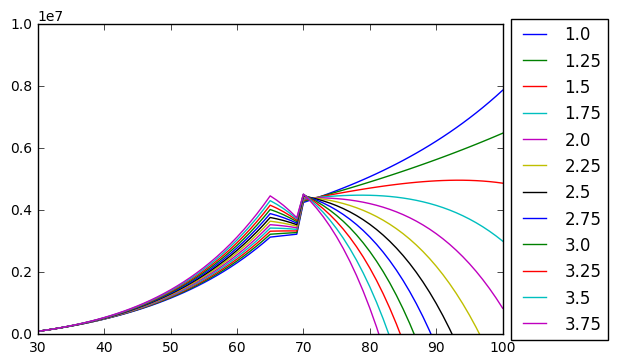

In [44]:
Retirement().interact()